## Data Exploration

In [1]:
import matplotlib.pyplot as plt
import os
import pathlib
import cv2
from sklearn.model_selection import train_test_split

In [2]:
data_dir = './data'
categories = ['Hand', 'ChestCT', 'HeadCT', 'AbdomenCT', 'CXR']

image_paths = {}
for category in categories:
    path = os.path.join(data_dir, category)
    label = category
    image_path_list = [os.path.join(path, f) for f in os.listdir(path)]
    image_paths[label] = image_path_list


Hand image shape: (64, 64, 3)
Hand image number: 10000
ChestCT image shape: (64, 64, 3)
ChestCT image number: 10000
HeadCT image shape: (64, 64, 3)
HeadCT image number: 10000
AbdomenCT image shape: (64, 64, 3)
AbdomenCT image number: 10000
CXR image shape: (64, 64, 3)
CXR image number: 10000


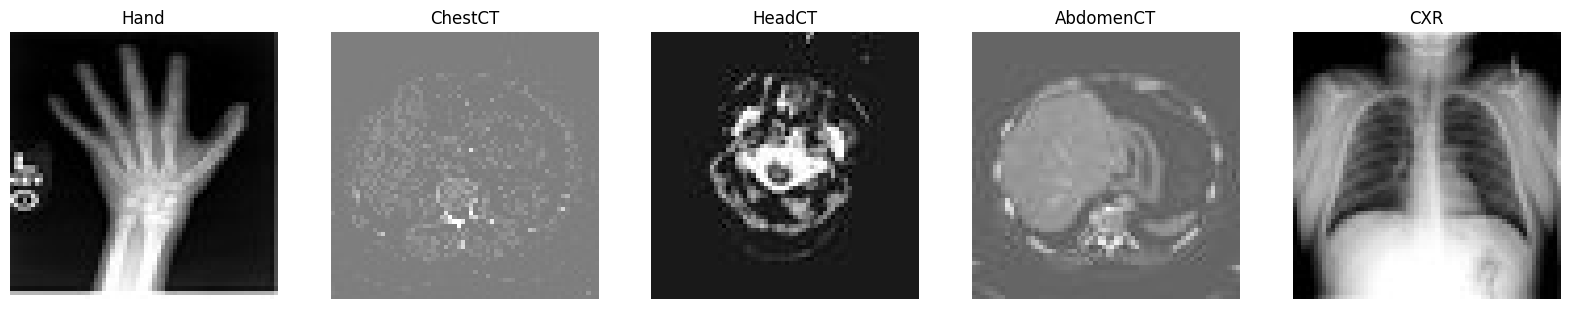

In [3]:
fig, axs = plt.subplots(1, len(categories), figsize=(20, 20))
for i, category in enumerate(categories):
    image_path = image_paths[category][0]
    image = cv2.imread(image_path)
    print(f"{category} image shape: {image.shape}")
    print(f"{category} image number: {len(image_paths[category])}")
    axs[i].imshow(image)
    axs[i].set_title(category)
    axs[i].axis('off')
plt.show()

## Data Preprocessing

In [4]:
import numpy as np

In [5]:
X, y = [], []
for category in categories:
    for image_path in image_paths[category]:
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        X.append(image)
        y.append(categories.index(category))

X = np.array(X)
y = np.array(y)

X = X.reshape(X.shape[0], X.shape[1], X.shape[2], 1)
X = X / 255.0
y = np.eye(len(categories))[y]


In [6]:
def decode_one_hot(one_hot):
    return np.argmax(one_hot, axis=1)


In [7]:
print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")


X shape: (50000, 64, 64, 1)
y shape: (50000, 5)


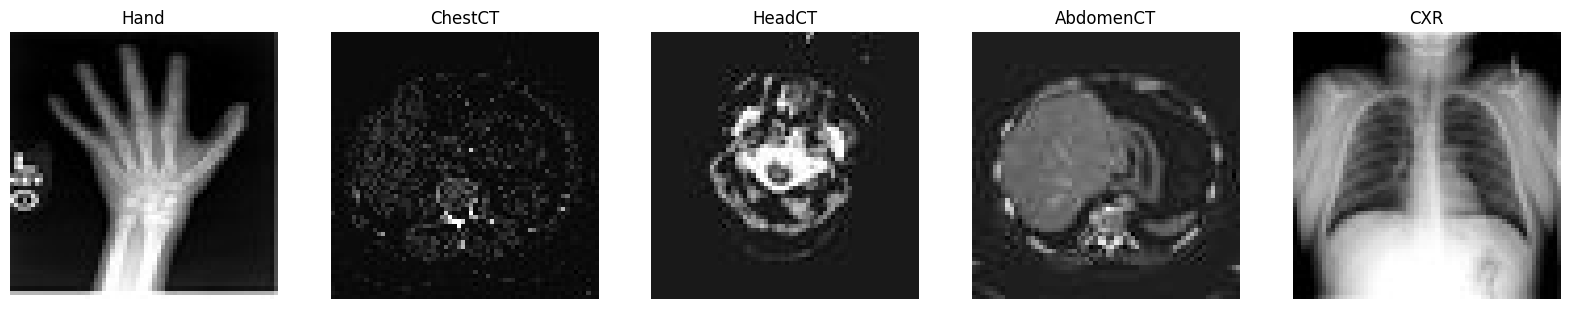

In [8]:
fig, axs = plt.subplots(1, len(categories), figsize=(20, 20))
for i, category in enumerate(categories):
    image = X[decode_one_hot(y) == i][0]
    axs[i].imshow(image, cmap='gray')
    axs[i].set_title(category)
    axs[i].axis('off')

In [9]:
train_x, test_x, train_y, test_y = train_test_split(X, y, test_size=0.2, random_state=42)

## Building the CNN

In [10]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import models

In [11]:
model = models.Sequential()
model.add(layers.Conv2D(16, (3, 3), activation='relu', input_shape=(64, 64, 1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(32, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(len(categories), activation='softmax'))

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 62, 62, 16)        160       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 31, 31, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 29, 29, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 14, 14, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 12, 12, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 6, 6, 64)         0

## Training the CNN

In [12]:
history = model.fit(train_x, train_y, epochs=10, validation_split=0.2, shuffle=True)

Epoch 1/10


2023-03-14 01:42:59.470492: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


1000/1000 [==============================] - 21s 21ms/step - loss: 0.0721 - accuracy: 0.9781 - val_loss: 0.0102 - val_accuracy: 0.9974
Epoch 2/10
1000/1000 [==============================] - 21s 21ms/step - loss: 0.0076 - accuracy: 0.9981 - val_loss: 0.0370 - val_accuracy: 0.9919
Epoch 3/10
1000/1000 [==============================] - 22s 22ms/step - loss: 0.0063 - accuracy: 0.9980 - val_loss: 0.0082 - val_accuracy: 0.9977
Epoch 4/10
1000/1000 [==============================] - 22s 22ms/step - loss: 0.0052 - accuracy: 0.9986 - val_loss: 0.0216 - val_accuracy: 0.9940
Epoch 5/10
1000/1000 [==============================] - 23s 23ms/step - loss: 0.0049 - accuracy: 0.9983 - val_loss: 0.0031 - val_accuracy: 0.9987
Epoch 6/10
1000/1000 [==============================] - 23s 23ms/step - loss: 0.0028 - accuracy: 0.9991 - val_loss: 0.0186 - val_accuracy: 0.9951
Epoch 7/10
1000/1000 [==============================] - 25s 25ms/step - loss: 0.0029 - accuracy: 0.9991 - val_loss: 0.0072 - val_accura

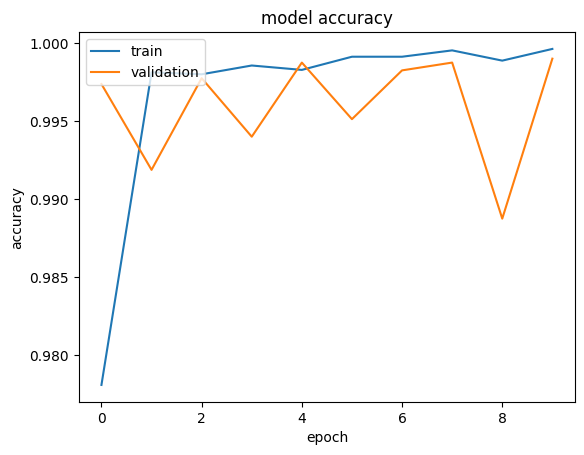

In [13]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

## Evaluating on test data

In [14]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [15]:
pred_y = model.predict(test_x)
pred_y = decode_one_hot(pred_y)
test_y = decode_one_hot(test_y)

313/313 [==============================] - 2s 6ms/step


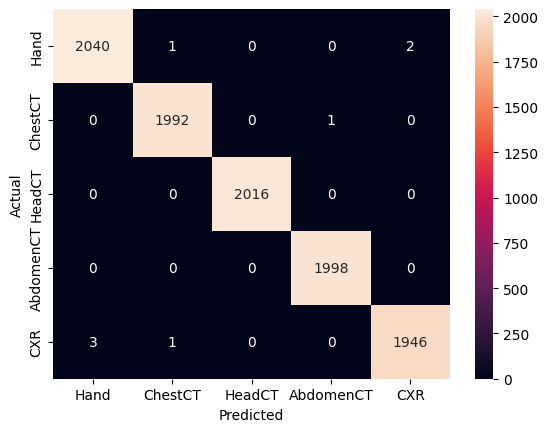

In [16]:
cm = confusion_matrix(test_y, pred_y)
sns.heatmap(cm, annot=True, fmt='d',
            xticklabels=categories, yticklabels=categories)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()
